In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import necessary modules
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
# import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [3]:
DATA_PATH = r'/home/rlfowler/Documents/research/tfo_inverse_modelling/Randalls Folder/data/randall_data_intensities.pkl'
#CONFIG_PATH = r'/home/rlfowler/Documents/research/tfo_sim/data/compiled_intensity/randall_data.json'

# Load the data
data = pd.read_pickle(DATA_PATH)
print(data.shape)
data.head()

(35929014, 47)


,Maternal Wall Thickness,Fetal Radius,Fetal Displacement,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation,10.0_1.0,15.0_1.0,19.0_1.0,...,55.0_2.0,59.0_2.0,64.0_2.0,68.0_2.0,72.0_2.0,77.0_2.0,81.0_2.0,86.0_2.0,90.0_2.0,94.0_2.0
43923,2.0,50.0,5.0,11.0,0.9,10.725,0.10,0.000041,0.000005,0.000001,...,6.001589e-15,5.848743e-15,2.763929e-16,1.500358e-17,3.398607e-18,1.015295e-18,7.130597e-20,8.710054e-22,4.012456e-20,2.355748e-22
43924,2.0,50.0,5.0,11.0,0.9,10.725,0.15,0.000041,0.000005,0.000001,...,5.893694e-15,5.768395e-15,2.710312e-16,1.463642e-17,3.212955e-18,9.575111e-19,6.831444e-20,8.155644e-22,3.835888e-20,2.151092e-22
43925,2.0,50.0,5.0,11.0,0.9,10.725,0.20,0.000041,0.000005,0.000001,...,5.789363e-15,5.689761e-15,2.658178e-16,1.428727e-17,3.039417e-18,9.030257e-19,6.545149e-20,7.646231e-22,3.667090e-20,1.964215e-22
43926,2.0,50.0,5.0,11.0,0.9,10.725,0.25,0.000041,0.000005,0.000001,...,5.688417e-15,5.612798e-15,2.607455e-16,1.395518e-17,2.877101e-18,8.516513e-19,6.271132e-20,7.177746e-22,3.505719e-20,1.793575e-22
43927,2.0,50.0,5.0,11.0,0.9,10.725,0.30,0.000041,0.000005,0.000001,...,5.590720e-15,5.537444e-15,2.558081e-16,1.363931e-17,2.725183e-18,8.032090e-19,6.008842e-20,6.746510e-22,3.351450e-20,1.637759e-22


In [4]:
## Scale y
from sklearn import preprocessing

y_columns = data.columns[:7]#["Fetal Saturation"]
x_columns = data.columns[7:]

y_scaler = preprocessing.StandardScaler()
data[y_columns] = y_scaler.fit_transform(data[y_columns])

x_scaler = preprocessing.StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])

In [5]:
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42    # Set the random seed for reproducibility
SAMPLE_SIZE = 0.05   # Set the sample size from the data
TEST_SIZE = 0.2     # Set the test size for the train/test split

# Split the data into training and testing sets # Might want to remove randomness for param selection
train_data, test_data = train_test_split(data.sample(frac=SAMPLE_SIZE, random_state=RANDOM_SEED) , test_size=TEST_SIZE, random_state=RANDOM_SEED)
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Split the data into input and output
x_train = train_data.iloc[:, 7:]
x_test = test_data.iloc[:, 7:]
y_train = train_data.iloc[:,:7]
y_test = test_data.iloc[:,:7]
print(f"x_train columns: {x_train.columns.tolist()}")
print(f"y_train columns: {y_train.columns.tolist()}")

del data, train_data, test_data

Train data shape: (1437160, 47)
Test data shape: (359291, 47)
x_train columns: ['10.0_1.0', '15.0_1.0', '19.0_1.0', '24.0_1.0', '28.0_1.0', '33.0_1.0', '37.0_1.0', '41.0_1.0', '46.0_1.0', '50.0_1.0', '55.0_1.0', '59.0_1.0', '64.0_1.0', '68.0_1.0', '72.0_1.0', '77.0_1.0', '81.0_1.0', '86.0_1.0', '90.0_1.0', '94.0_1.0', '10.0_2.0', '15.0_2.0', '19.0_2.0', '24.0_2.0', '28.0_2.0', '33.0_2.0', '37.0_2.0', '41.0_2.0', '46.0_2.0', '50.0_2.0', '55.0_2.0', '59.0_2.0', '64.0_2.0', '68.0_2.0', '72.0_2.0', '77.0_2.0', '81.0_2.0', '86.0_2.0', '90.0_2.0', '94.0_2.0']
y_train columns: ['Maternal Wall Thickness', 'Fetal Radius', 'Fetal Displacement', 'Maternal Hb Concentration', 'Maternal Saturation', 'Fetal Hb Concentration', 'Fetal Saturation']


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE = 32 #128, 32


# Create a dataloader
train_dataset = TensorDataset(torch.tensor(x_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(x_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
# Hyperparameters
from typing import Optional, List
from torch.optim import SGD, Optimizer


# Create a neural network
class Net(nn.Module):
    
    layers: List[nn.Module] = []     # List of layers
    model: nn.Module            # The model
    training_loss: List[float] = []  # Training loss
    validation_loss: List[float] = []# Validation loss

    def __init__(self, node_count: List[int], dropout_rates: Optional[List[float]]):
        super(Net, self).__init__()
        #self.layers = []
        for indx, n_nodes in enumerate(node_count[:-2]):
            self.layers.append(nn.Linear(n_nodes, node_count[indx+1]))
            self.layers.append(nn.BatchNorm1d(node_count[indx+1]))
            if dropout_rates:
                self.layers.append(nn.Dropout(dropout_rates[indx]))
            self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(node_count[-2], node_count[-1]))   # Output layer
        self.model = nn.Sequential(*self.layers)
        self.model.cuda()

    def _default_optimizer(self):
        return SGD(self.model.parameters(), lr=0.001, momentum=0.9)
        
    def forward(self, x):
        return self.model(x)
    
    def train(self, train_loader, criterion:nn.Module = nn.MSELoss(), optimizer:Optimizer = None, n_epochs:int = 1, verbose:bool = False):
        if optimizer is None:
            optimizer = self._default_optimizer()
        batch_size = train_loader.batch_size

        self.model.train()  # Set the model to training mode
        print("Starting training...")
        print(f"Length of train_loader: {len(train_loader)}")
        for epoch in range(n_epochs):
            running_loss = 0.0
            for step, (batch_x, batch_y) in enumerate(train_loader):
                batch_x = batch_x.cuda()    # Send the data to the GPU
                batch_y = batch_y.cuda()    # Send the data to the GPU

                output = self.forward(batch_x)                      # Forward pass
                loss = criterion(output, batch_y)                   # Compute the loss
                optimizer.zero_grad()                               # Zero the gradients to prevent accumulation
                loss.backward()                                     # Backpropagation to compute the gradients                   
                optimizer.step()                                    # Update the weights, apply gradients        

                running_loss += loss.item()                         # Add the loss to the running loss

                if verbose and step % batch_size == 0:                    # Print stats every 100 steps
                    print(f"Epoch: {epoch}, Step: {step}, Loss: {loss.item()}")
                    # accuracy = torch.sum(torch.abs(output - batch_y) < 0.1).item() / len(batch_y)
                    # print(f"Epoch: {epoch}, Loss: {loss.item()}, Accuracy: {accuracy}")
            self.training_loss.append(running_loss/len(train_loader))  # Append the average loss to the training loss list

    def predict(self, test_loader, criterion:nn.Module = nn.MSELoss(), verbose=False):
        self.model.eval()
        running_loss = 0.0
        accuracy = 0.0
        print("Starting prediction...")
        for step, (batch_x, batch_y) in enumerate(test_loader):
            # Send the data to the GPU
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            
            with torch.no_grad():
                output = self.model(batch_x)
                loss = criterion(output, batch_y)

            # acc = torch.sum(torch.abs(output - batch_y) < 0.1).item() / len(batch_y)
            # accuracy += acc
            running_loss += loss.item()

            if verbose:
                print(f"Loss: {loss.item()}")#, Accuracy: {acc}")

        accuracy /= len(test_loader)
        running_loss /= len(test_loader)
        self.validation_loss.append(running_loss)
        return running_loss, accuracy


In [6]:
dropout_rates = [0.4, 0.4, 0.4] # also try [0.5, 0.5, 0.5]  # Dropout rates for each layer except output
model = Net([x_train.shape[1], 20, 10, 10, y_train.shape[1]], dropout_rates)
model.train(train_loader, verbose=True)
model.predict(test_loader, verbose=True)

Starting training...
Length of train_loader: 44912
Epoch: 0, Step: 0, Loss: 1.1372438669204712
Epoch: 0, Step: 32, Loss: 1.1397991180419922
Epoch: 0, Step: 64, Loss: 1.2058676481246948
Epoch: 0, Step: 96, Loss: 1.0624178647994995
Epoch: 0, Step: 128, Loss: 1.0510165691375732
Epoch: 0, Step: 160, Loss: 1.0430290699005127
Epoch: 0, Step: 192, Loss: 1.020845651626587
Epoch: 0, Step: 224, Loss: 0.9556018710136414
Epoch: 0, Step: 256, Loss: 1.0091766119003296
Epoch: 0, Step: 288, Loss: 0.9234088063240051
Epoch: 0, Step: 320, Loss: 1.065679907798767
Epoch: 0, Step: 352, Loss: 1.0721863508224487
Epoch: 0, Step: 384, Loss: 0.9288445115089417
Epoch: 0, Step: 416, Loss: 0.8492509126663208
Epoch: 0, Step: 448, Loss: 0.9661723971366882
Epoch: 0, Step: 480, Loss: 0.9058165550231934
Epoch: 0, Step: 512, Loss: 1.058016061782837
Epoch: 0, Step: 544, Loss: 0.9503112435340881
Epoch: 0, Step: 576, Loss: 1.0322074890136719
Epoch: 0, Step: 608, Loss: 0.8818583488464355
Epoch: 0, Step: 640, Loss: 0.90453559

(0.7480336576063182, 0.0)

In [7]:
print(model)

NameError: name 'model' is not defined

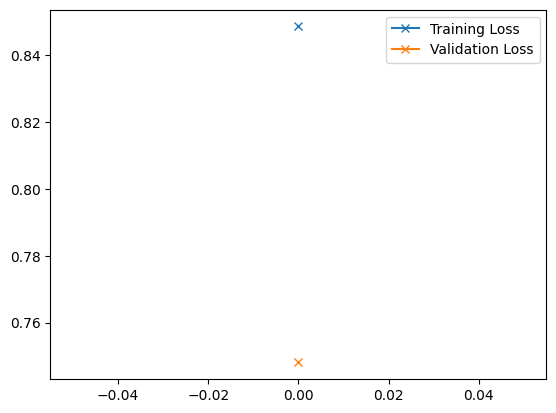

In [11]:
plt.figure()
plt.plot(model.training_loss, label='Training Loss', marker='x')
plt.plot(model.validation_loss, label='Validation Loss', marker='x')
# plt.yscale('log')
# plt.xlim([0, 10])
plt.legend()

In [12]:
print(model.training_loss)
print(model.validation_loss)

[0.848636972438909]
[0.7480336576063182]


In [8]:
import joblib

model_name = "model1"

# Save the model weights
torch.save(model.state_dict(), rf'models/{model_name}_weights.pth')
# joblib.dump(x_scaler, rf'../models/{model_name}_xscaler') # stores in folder 2 levels up and in models folder
# joblib.dump(y_scaler, rf'../models/{model_name}_yscaler')
joblib.dump(x_scaler, rf'models/{model_name}_xscaler')
joblib.dump(y_scaler, rf'models/{model_name}_yscaler')

NameError: name 'model' is not defined

Make sure the old model doesn't exist here. Not sure why but new model will contain old model layers. Cannot create new model while old model exists...

In [10]:
dropout_rates = [0.4, 0.4, 0.4]

model_name = "model1"

# Create an instance of the model
new_model = Net([40, 20, 10, 10, 7], dropout_rates)
print(new_model)

# Load the saved weights
model_weights = rf'models/{model_name}_weights.pth'
new_model.load_state_dict(torch.load(model_weights))

Net(
  (model): Sequential(
    (0): Linear(in_features=40, out_features=20, bias=True)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.4, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
    (5): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.4, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=10, bias=True)
    (9): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.4, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=10, out_features=7, bias=True)
  )
)


<All keys matched successfully>